# Восстановление золота из руды

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий.

Цель проекта - подготовить прототип модели машинного обучения для «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В нашем распоряжении данные с параметрами добычи и очистки. Данные сырые: их просто выгрузили из хранилища.
Данные находятся в трёх файлах:
-	gold_recovery_train_new.csv — обучающая выборка;
-	gold_recovery_test_new.csv — тестовая выборка;
-	gold_recovery_full_new.csv — исходные данные.

Описание данных

Технологический процесс
-	Rougher feed — исходное сырье
-	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
-	Xanthate — ксантогенат (промотер, или активатор флотации);
-	Sulphate — сульфат (на данном производстве сульфид натрия);
-	Depressant — депрессант (силикат натрия).
-	Rougher process (англ. «грубый процесс») — флотация
-	Rougher tails — отвальные хвосты
-	Float banks — флотационная установка
-	Cleaner process — очистка
-	Rougher Au — черновой концентрат золота
-	Final Au — финальный концентрат золота

Параметры этапов
-	air amount — объём воздуха
-	fluid levels — уровень жидкости
-	feed size — размер гранул сырья
-	feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:
-	rougher — флотация
-	primary_cleaner — первичная очистка
-	secondary_cleaner — вторичная очистка
-	final — финальные характеристики

Возможные значения для блока [тип_параметра]:
-	input — параметры сырья
-	output — параметры продукта
-	state — параметры, характеризующие текущее состояние этапа
-	calculation — расчётные характеристики

Для реализации поставленной цели будут выполнены следующие шаги:

1. Подготовка данных;
2. Проведение исследовательского анализа данных;
3. Построение и обучение модели.


##1 Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

###1.1 Открытие и изучение файлов

In [ ]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
df_full.head()

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   

   secondary_cleaner.state.floatbank4_b_air  \
0                                 12.099931   
1                                 11.950531   
2                                 11.912783   
3                                 11.999550   
4                                 11.953070   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -504.715942   
1                                 -501.331529   
2                                 -501.133383   
3                                 -501.193686   
4                                 -501.053894   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  9.925633   
1                                 10.039245   
2                                 10.070913   
3                                  9.970366   
4                                  9.925709   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -498.310211   
1                                 -500.169983   
2                                 -500.129135   
3                                 -499.201640   
4                                 -501.686727   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  8.079666   
1                                  7.984757   
2                                  8.013877   
3                                  7.977324   
4                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0    

In [ ]:
df_train.head()

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   

   secondary_cleaner.state.floatbank4_b_air  \
0                                 12.099931   
1                                 11.950531   
2                                 11.912783   
3                                 11.999550   
4                                 11.953070   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -504.715942   
1                                 -501.331529   
2                                 -501.133383   
3                                 -501.193686   
4                                 -501.053894   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  9.925633   
1                                 10.039245   
2                                 10.070913   
3                                  9.970366   
4                                  9.925709   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -498.310211   
1                                 -500.169983   
2                                 -500.129135   
3                                 -499.201640   
4                                 -501.686727   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  8.079666   
1                                  7.984757   
2                                  8.013877   
3                                  7.977324   
4                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0    

In [ ]:
df_test.head()

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                             1400.129303  ...   
4                             1402.172226  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 12.023554   
1                                 12.058140   
2                                 11.962366   
3                                 12.033091   
4                                 12.025367   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -497.795834   
1                                 -498.695773   
2                                 -498.767484   
3                                 -498.350935   
4                                 -500.786497   

   secondary_cleaner.state.floatbank4_b_air  \
0                                  8.016656   
1                                  8.130979   
2                                  8.096893   
3                                  8.074946   
4                                  8.054678   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -501.289139   
1                                 -499.634209   
2                                 -500.827423   
3                                 -499.474407   
4                                 -500.397500   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  7.946562   
1                                  7.958270   
2                                  8.071056   
3                                  7.897085   
4                                  8.107890   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -432.317850   
1                                 -525.839648   
2                                 -500.801673   
3     

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_full.describe()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 19438.000000                 19438.000000   
mean                      5.168470                     9.978895   
std                       1.372348                     1.669240   
min                       0.000000                     0.000000   
25%                       4.251240                     9.137262   
50%                       5.066094                    10.102433   
75%                       5.895527                    11.035769   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  19228.000000                 19439.000000   
mean                       9.501224                    44.076513   
std                        2.787537                     5.129784   
min                        0.000000                     0.000000   
25%                        7.722820                    43.402215   
50%                        9.218961                    45.011244   
75%                       10.947813                    46.275313   
max                       19.615720                    52.756638   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           19439.000000          19438.000000          19338.000000   
mean               67.050208              9.688589              2.705795   
std                10.125840              2.328642              0.949077   
min                 0.000000              0.000000              0.000000   
25%                63.299712              8.062878              2.040119   
50%                68.172738              9.743623              2.748730   
75%                72.686642             11.134294              3.333216   
max               100.000000             19.552149              5.804178   

       final.output.tail_sol  final.output.tail_au  \
count           19433.000000          19439.000000   
mean               10.583728              3.042467   
std                 2.868782              0.922808   
min                 0.000000              0.000000   
25%                 8.938947              2.461138   
50%                10.622456              2.984909   
75%                12.104271              3.571351   
max                22.317730              8.245022   

       primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                   19415.000000                      19402.000000   
mean                      144.624774                          8.817039   
std                        44.464071                          3.286186   
min                         0.003112                          0.000000   
25%                       114.107029                          6.076909   
50%                       143.232103                          8.038311   
75%                       175.075656                         11.013521   
max                       265.983123                         40.000000   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                     19439.000000                    19335.000000   
mean                          7.307078                        1.021795   
std                           0.613509                        0.513254   
min                           1.080000                        0.000005   
25%                           6.940000                        0.697224   
50%                           7.280000                        0.940863   
75%                           7.670000                        1.210990   
max                          15.500000                        4.102454   

       primary_cleaner.output.concentrate_ag  \
count                           19439.000000   
mean                                8.442408   
std                                 2.054465   
min                                 0.000000   
25%                                 7.263288

In [ ]:
df_train.describe()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    43.276111   
50%                        8.845462                    44.872436   
75%                       10.487508                    46.166425   
max                       18.124851                    52.756638   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           14149.000000          14149.000000          14049.000000   
mean               66.518832              9.607035              2.597298   
std                10.295402              2.319069              0.971843   
min                 0.000000              0.000000              0.000000   
25%                62.545817              7.997429              1.905973   
50%                67.432775              9.480270              2.592022   
75%                72.346428             11.003707              3.241723   
max               100.000000             19.552149              5.639565   

       final.output.tail_sol  final.output.tail_au  \
count           14144.000000          14149.000000   
mean               10.512122              2.918421   
std                 3.003617              0.903712   
min                 0.000000              0.000000   
25%                 8.811324              2.368607   
50%                10.514621              2.851025   
75%                11.933009              3.434764   
max                22.317730              8.197408   

       primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                   14129.000000                      14117.000000   
mean                      133.320659                          8.866996   
std                        39.431659                          3.361589   
min                         0.003112                          0.000000   
25%                       107.006651                          6.040604   
50%                       133.018328                          8.035811   
75%                       159.825396                         11.522173   
max                       250.127834                         20.052255   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                     14149.000000                    14049.000000   
mean                          7.322310                        0.885588   
std                           0.614062                        0.372714   
min                           1.080000                        0.000005   
25%                           6.960000                        0.607021   
50%                           7.290000                        0.888749   
75%                           7.700000                        1.100933   
max                          10.470000                        2.512968   

       primary_cleaner.output.concentrate_ag  \
count                           14149.000000   
mean                                8.200916   
std                                 2.005185   
min                                 0.000000   
25%                                 7.107126

In [ ]:
df_test.describe()

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                    5286.000000                       5285.000000   
mean                      174.839652                          8.683596   
std                        43.027080                          3.072050   
min                         2.566156                          0.003839   
25%                       147.121401                          6.489555   
50%                       177.828489                          8.052207   
75%                       208.125438                         10.027764   
max                       265.983123                         40.000000   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                      5290.000000                     5286.000000   
mean                          7.266339                        1.383803   
std                           0.610219                        0.643474   
min                           5.650000                        0.004984   
25%                           6.890000                        0.907623   
50%                           7.250000                        1.197610   
75%                           7.600000                        1.797819   
max                          15.500000                        4.102454   

       primary_cleaner.state.floatbank8_a_air  \
count                            5.290000e+03   
mean                             1.539494e+03   
std                              1.167979e+02   
min                              5.445860e-32   
25%                              1.498936e+03   
50%                              1.585129e+03   
75%                              1.602077e+03   
max                              2.103104e+03   

       primary_cleaner.state.floatbank8_a_level  \
count                               5290.000000   
mean                                -497.665883   
std                                   19.952431   
min                                 -795.316337   
25%                                 -500.357298   
50%                                 -499.969164   
75%                                 -499.568951   
max                                  -57.195404   

       primary_cleaner.state.floatbank8_b_air  \
count                            5.290000e+03   
mean                             1.545174e+03   
std                              1.222246e+02   
min                              6.647490e-32   
25%                              1.498971e+03   
50%                              1.595622e+03   
75%                              1.602324e+03   
max                              1.813084e+03   

       primary_cleaner.state.floatbank8_b_level  \
count                               5290.000000   
mean                                -500.273098   
std                                   32.968307   
min                                 -799.997015   
25%                                 -500.703002   
50%                                 -500.028514   
75%                                 -499.293257   
max                                 -142.527229   

       primary_cleaner.state.floatbank8_c_air  \
count                            5.290000e+03   
mean                             1.527272e+03   
std                              1.225380e+02   
min                              4.033736e-32   
25%                              1.473230e+03   
50%                              1.549595e+03   
75%                              1.601144e+03   
max                              1.715054e+03   

       primary_cleaner.state.floatbank8_c_level  \
count                               5290.000000   
mean                                -498.330680   
std                                   21.964876   
min                                 -799.960571   
25%                                 -501.018117   
50%                                 -500.017711   
75%                                 -498.994130   
max                

In [ ]:
pd.set_option('display.max_row', None)
df_full.corr()

final.output.concentrate_ag  \
final.output.concentrate_ag                                            1.000000   
final.output.concentrate_pb                                            0.063570   
final.output.concentrate_sol                                           0.380142   
final.output.concentrate_au                                           -0.038373   
final.output.recovery                                                  0.185952   
final.output.tail_ag                                                   0.334596   
final.output.tail_pb                                                  -0.051855   
final.output.tail_sol                                                  0.028890   
final.output.tail_au                                                   0.206569   
primary_cleaner.input.sulfate                                          0.071158   
primary_cleaner.input.depressant                                       0.127827   
primary_cleaner.input.feed_size                                        0.040543   
primary_cleaner.input.xanthate                                         0.127175   
primary_cleaner.output.concentrate_ag                                  0.509877   
primary_cleaner.output.concentrate_pb                                 -0.152814   
primary_cleaner.output.concentrate_sol                                 0.332771   
primary_cleaner.output.concentrate_au                                 -0.200367   
primary_cleaner.output.tail_ag                                         0.043138   
primary_cleaner.output.tail_pb                                        -0.023182   
primary_cleaner.output.tail_sol                                        0.175824   
primary_cleaner.output.tail_au                                         0.163903   
primary_cleaner.state.floatbank8_a_air                                 0.175978   
primary_cleaner.state.floatbank8_a_level                               0.039789   
primary_cleaner.state.floatbank8_b_air                                 0.194615   
primary_cleaner.state.floatbank8_b_level                               0.058284   
primary_cleaner.state.floatbank8_c_air                                 0.154360   
primary_cleaner.state.floatbank8_c_level                               0.036542   
primary_cleaner.state.floatbank8_d_air                                 0.110360   
primary_cleaner.state.floatbank8_d_level                              -0.001388   
rougher.calculation.sulfate_to_au_concentrate                         -0.014190   
rougher.calculation.floatbank10_sulfate_to_au_feed                    -0.034702   
rougher.calculation.floatbank11_sulfate_to_au_feed                    -0.039130   
rougher.calculation.au_pb_ratio                                        0.158668   
rougher.input.feed_ag                                                  0.456279   
rougher.input.feed_pb                                                  0.074866   
rougher.input.feed_rate                                               -0.167154   
rougher.input.feed_size                                               -0.043895   
rougher.input.feed_sol                                                -0.036783   
rougher.input.feed_au                                                  0.315817   
rougher.input.floatbank10_sulfate                                     -0.096561   
rougher.input.floatbank10_xanthate                                     0.093678   
rougher.input.floatbank11_sulfate                                     -0.113477   
rougher.input.floatbank11_xanthate                                     0.114032   
rougher.output.concentrate_ag                                          0.315558   
rougher.output.concentrate_pb                                         -0.127291   
rougher.output.concentrate_sol                                        -0.018497   
rougher.output.concentrate_au                                          0.044347   
rougher.output.recovery                                             

In [ ]:
df_full.corr()['final.output.recovery'].sort_values(ascending=False)

final.output.recovery                                 1.000000
primary_cleaner.input.sulfate                         0.366954
rougher.input.floatbank11_xanthate                    0.328231
rougher.input.floatbank10_xanthate                    0.328066
rougher.output.recovery                               0.327059
rougher.input.feed_au                                 0.295343
final.output.concentrate_au                           0.288568
rougher.input.feed_ag                                 0.286823
final.output.concentrate_sol                          0.265993
primary_cleaner.output.concentrate_ag                 0.265488
rougher.input.feed_sol                                0.250058
primary_cleaner.output.concentrate_sol                0.210740
primary_cleaner.input.xanthate                        0.206445
rougher.output.concentrate_ag                         0.195862
final.output.concentrate_ag                           0.185952
rougher.state.floatbank10_a_air                       0

In [ ]:
df_full.corr()['rougher.output.recovery'].sort_values(ascending=False)

rougher.output.recovery                               1.000000
rougher.output.concentrate_ag                         0.661330
rougher.output.concentrate_sol                        0.604420
rougher.output.concentrate_au                         0.579638
rougher.output.concentrate_pb                         0.552622
final.output.recovery                                 0.327059
primary_cleaner.input.sulfate                         0.279260
rougher.input.floatbank10_xanthate                    0.244823
rougher.input.floatbank11_xanthate                    0.241153
secondary_cleaner.state.floatbank4_b_air              0.227642
secondary_cleaner.state.floatbank4_a_air              0.212177
rougher.input.feed_sol                                0.197475
primary_cleaner.output.concentrate_ag                 0.189857
final.output.tail_ag                                  0.187328
rougher.input.feed_ag                                 0.184625
rougher.input.feed_pb                                 0

In [ ]:
df_train.corr()

final.output.concentrate_ag  \
final.output.concentrate_ag                                            1.000000   
final.output.concentrate_pb                                            0.021110   
final.output.concentrate_sol                                           0.351985   
final.output.concentrate_au                                           -0.104934   
final.output.recovery                                                  0.133238   
final.output.tail_ag                                                   0.289552   
final.output.tail_pb                                                  -0.099818   
final.output.tail_sol                                                  0.045896   
final.output.tail_au                                                   0.193935   
primary_cleaner.input.sulfate                                          0.015923   
primary_cleaner.input.depressant                                       0.136008   
primary_cleaner.input.feed_size                                        0.024921   
primary_cleaner.input.xanthate                                         0.165403   
primary_cleaner.output.concentrate_ag                                  0.502774   
primary_cleaner.output.concentrate_pb                                 -0.176998   
primary_cleaner.output.concentrate_sol                                 0.315810   
primary_cleaner.output.concentrate_au                                 -0.185916   
primary_cleaner.output.tail_ag                                        -0.001483   
primary_cleaner.output.tail_pb                                        -0.062081   
primary_cleaner.output.tail_sol                                        0.165046   
primary_cleaner.output.tail_au                                         0.191298   
primary_cleaner.state.floatbank8_a_air                                 0.188219   
primary_cleaner.state.floatbank8_a_level                               0.041814   
primary_cleaner.state.floatbank8_b_air                                 0.203256   
primary_cleaner.state.floatbank8_b_level                               0.053429   
primary_cleaner.state.floatbank8_c_air                                 0.165760   
primary_cleaner.state.floatbank8_c_level                               0.043158   
primary_cleaner.state.floatbank8_d_air                                 0.098070   
primary_cleaner.state.floatbank8_d_level                               0.007139   
rougher.calculation.sulfate_to_au_concentrate                         -0.016921   
rougher.calculation.floatbank10_sulfate_to_au_feed                    -0.027763   
rougher.calculation.floatbank11_sulfate_to_au_feed                    -0.037668   
rougher.calculation.au_pb_ratio                                        0.195373   
rougher.input.feed_ag                                                  0.424378   
rougher.input.feed_pb                                                  0.004272   
rougher.input.feed_rate                                               -0.177363   
rougher.input.feed_size                                               -0.021952   
rougher.input.feed_sol                                                -0.045802   
rougher.input.feed_au                                                  0.276645   
rougher.input.floatbank10_sulfate                                     -0.115623   
rougher.input.floatbank10_xanthate                                     0.069868   
rougher.input.floatbank11_sulfate                                     -0.140668   
rougher.input.floatbank11_xanthate                                     0.087768   
rougher.output.concentrate_ag                                          0.288717   
rougher.output.concentrate_pb                                         -0.167535   
rougher.output.concentrate_sol                                        -0.042561   
rougher.output.concentrate_au                                          0.033109   
rougher.output.recovery                                             

In [ ]:
df_test.corr()

primary_cleaner.input.sulfate  \
primary_cleaner.input.sulfate                                    1.000000   
primary_cleaner.input.depressant                                 0.455718   
primary_cleaner.input.feed_size                                  0.114456   
primary_cleaner.input.xanthate                                   0.497568   
primary_cleaner.state.floatbank8_a_air                           0.102653   
primary_cleaner.state.floatbank8_a_level                         0.048032   
primary_cleaner.state.floatbank8_b_air                           0.075737   
primary_cleaner.state.floatbank8_b_level                         0.138949   
primary_cleaner.state.floatbank8_c_air                           0.024710   
primary_cleaner.state.floatbank8_c_level                         0.027697   
primary_cleaner.state.floatbank8_d_air                           0.095001   
primary_cleaner.state.floatbank8_d_level                        -0.020533   
rougher.input.feed_ag                                            0.359619   
rougher.input.feed_pb                                            0.428382   
rougher.input.feed_rate                                          0.464251   
rougher.input.feed_size                                         -0.009796   
rougher.input.feed_sol                                           0.423859   
rougher.input.feed_au                                            0.437016   
rougher.input.floatbank10_sulfate                                0.617768   
rougher.input.floatbank10_xanthate                               0.557307   
rougher.input.floatbank11_sulfate                                0.583022   
rougher.input.floatbank11_xanthate                               0.527014   
rougher.state.floatbank10_a_air                                  0.236898   
rougher.state.floatbank10_a_level                                0.222913   
rougher.state.floatbank10_b_air                                 -0.230670   
rougher.state.floatbank10_b_level                               -0.047665   
rougher.state.floatbank10_c_air                                 -0.247043   
rougher.state.floatbank10_c_level                               -0.051896   
rougher.state.floatbank10_d_air                                 -0.247163   
rougher.state.floatbank10_d_level                               -0.016032   
rougher.state.floatbank10_e_air                                 -0.234958   
rougher.state.floatbank10_e_level                               -0.120379   
rougher.state.floatbank10_f_air                                 -0.250187   
rougher.state.floatbank10_f_level                               -0.063497   
secondary_cleaner.state.floatbank2_a_air                         0.051989   
secondary_cleaner.state.floatbank2_a_level                      -0.039145   
secondary_cleaner.state.floatbank2_b_air                         0.254702   
secondary_cleaner.state.floatbank2_b_level                      -0.011921   
secondary_cleaner.state.floatbank3_a_air                         0.136986   
secondary_cleaner.state.floatbank3_a_level                       0.003869   
secondary_cleaner.state.floatbank3_b_air                         0.148037   
secondary_cleaner.state.floatbank3_b_level                       0.020303   
secondary_cleaner.state.floatbank4_a_air                         0.305793   
secondary_cleaner.state.floatbank4_a_level                       0.117976   
secondary_cleaner.state.floatbank4_b_air                         0.348395   
secondary_cleaner.state.floatbank4_b_level                       0.068693   
secondary_cleaner.state.floatbank5_a_air                         0.093608   
secondary_cleaner.state.floatbank5_a_level                       0.132193   
secondary_cleaner.state.floatbank5_b_air                         0.156583   
secondary_cleaner.state.floatbank5_b_level                       0.072618   
secondary_cleaner.state.floatbank6_a_air                        -0.134499   
secondary_cleaner.state.floatbank6_a_lev

Таблицы с данными df_full и df_train содержат одинаковое количество столбцов (87), df_test содержит всего 53 столбца. Все данные кроме столбца date имеют тип float64, date -  object. Во всех трех таблицах присутствуют пропуски. У целевого показателя 'rougher.output.recovery' присутствует средняя положительная корреляция с rougher.output.concentrate_ag, rougher.output.concentrate_sol, rougher.output.concentrate_au, rougher.output.concentrate_pb и слабая отрицательная с rougher.output.tail_pb,  rougher.output.tail_au, у целевого показателя 'final.output.recovery' присутствует слабая положительная корреляция  с primary_cleaner.input.sulfate,    rougher.input.floatbank11_xanthate, rougher.input.floatbank10_xanthate, rougher.output.recovery,   rougher.input.feed_au   rougher.input.feed_au, final.output.concentrate_au, rougher.input.feed_ag, final.output.concentrate_sol, primary_cleaner.output.concentrate_ag,  слабая отрицательная с rougher.output.tail_au, rougher.output.tail_pb,   secondary_cleaner.output.tail_au, primary_cleaner.output.tail_au, final.output.tail_au.          

###1.2 Проверка правильности расчета эффективности обогащения

In [ ]:
C = df_train['rougher.output.concentrate_au']

In [ ]:
F = df_train['rougher.input.feed_au']

In [ ]:
T = df_train['rougher.output.tail_au']

In [ ]:
check = (C*(F-T)/(F*(C-T)))*100

In [ ]:
mae = mean_absolute_error(check, df_train['rougher.output.recovery'])

In [ ]:
print('MAE:', mae)

MAE: 9.73512347450521e-15


 Полученное значение MAE практически равно 0, что говорит о том, что эффективность обогащения расчитан правильно.

###1.3 Признаки не доступные в тестовой выборке

In [ ]:
df_train.columns.difference(df_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовой выборке отсутствуют признаки, которые относятся к параметрам продукта на всех этапах технологического процесса, а также расчетные характеристики.

###1.4 Предобработка данных

Добавляем в тестовую выборку из исходного датасета отсутствующие столбцы:

In [ ]:
columns_test = df_full.columns.intersection(df_test.columns).tolist()

In [ ]:
columns_full = df_full.columns.difference(df_test.columns).tolist()

In [ ]:
columns_full.append('date')

In [ ]:
df_test = pd.merge(df_test, df_full[columns_full], on='date')

In [ ]:
columns_1 = df_train.columns.tolist()

In [ ]:
df_test = df_test.reindex(columns=columns_1)

In [ ]:
df_test.isna().sum().sum()

381

In [ ]:
df_test.head()

date  final.output.concentrate_ag  \
0  2016-09-01 00:59:59                     7.578381   
1  2016-09-01 01:59:59                     7.813838   
2  2016-09-01 02:59:59                     7.623392   
3  2016-09-01 03:59:59                     8.552457   
4  2016-09-01 04:59:59                     8.078781   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                    10.466295                     11.990938   
1                    10.581152                     12.216172   
2                    10.424024                     12.313710   
3                    10.503229                     13.074570   
4                    10.222788                     12.475427   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    40.743891              70.273583             12.688885   
1                    39.604292              68.910432             12.829171   
2                    40.724190              68.143213             12.977846   
3                    39.290997              67.776393             12.451947   
4                    40.254524              61.467078             11.827846   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  \
0              3.844413              11.075686              4.537988   
1              3.918901              11.132824              4.675117   
2              4.026561              10.990134              4.828907   
3              3.780702              11.155935              4.969620   
4              3.632272              11.403663              5.256806   

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     210.800909                         14.993118   
1                     215.392455                         14.987471   
2                     215.259946                         12.884934   
3                     215.336236                         12.006805   
4                     199.099327                         10.682530   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                         8.080000                        1.005021   
1                         8.080000                        0.990469   
2                         7.786667                        0.996043   
3                         7.640000                        0.863514   
4                         7.530000                        0.805575   

   primary_cleaner.output.concentrate_ag  \
0                              11.631910   
1                              11.563424   
2                              11.420389   
3                              12.345224   
4                              10.398173   

   primary_cleaner.output.concentrate_pb  \
0                              12.706851   
1                              12.587215   
2                              12.470523   
3                              12.689614   
4                              12.609439   

   primary_cleaner.output.concentrate_sol  \
0                               17.872038   
1                               18.063048   
2                               18.053777   
3                               19.358532   
4                               18.189253   

   primary_cleaner.output.concentrate_au  primary_cleaner.output.tail_ag  \
0                              28.364867                       17.266279   
1                              27.174515                       18.178924   
2                              27.694098                       18.988695   
3                              27.298256                       18.933287   
4                              31.650787                       18.318719   

   primary_cleaner.output.tail_pb  primary_cleaner.output.tail_sol  \
0                        4.148198                        11.034524   
1                        4.639624                        10.994805   
2                        5.042994                        10.864110   
3             

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                5290 non-null   object 
 1   final.output.concentrate_ag                         5290 non-null   float64
 2   final.output.concentrate_pb                         5290 non-null   float64
 3   final.output.concentrate_sol                        5290 non-null   float64
 4   final.output.concentrate_au                         5290 non-null   float64
 5   final.output.recovery                               5290 non-null   float64
 6   final.output.tail_ag                                5289 non-null   float64
 7   final.output.tail_pb                                5289 non-null   float64
 8   final.output.tail_sol                               5289 non-null   float64
 9

In [ ]:
df_train.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
primary_cleaner.input.xanthate                         100
rougher.input.feed_pb                                  100
final.output.tail_pb                                   100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol                          

In [ ]:
df_test.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol                     143
primary_cleaner.output.concentrate_sol                 84
primary_cleaner.output.concentrate_pb                  30
rougher.input.floatbank11_xanthate                     25
rougher.input.feed_sol                                 21
primary_cleaner.output.tail_sol                        16
secondary_cleaner.state.floatbank3_a_air                9
rougher.input.floatbank11_sulfate                       8
primary_cleaner.output.tail_pb                          6
rougher.input.floatbank10_sulfate                       5
primary_cleaner.input.depressant                        5
primary_cleaner.input.sulfate                           4
primary_cleaner.input.xanthate                          4
secondary_cleaner.state.floatbank2_a_air                3
rougher.input.feed_rate                                 3
primary_cleaner.output.tail_ag                          3
secondary_cleaner.output.tail_pb                        2
secondary_clea

In [ ]:
df_train = df_train.ffill(axis=0)

In [ ]:
df_train.isna().sum().sum()

0

In [ ]:
df_test = df_test.ffill(axis=0)

In [ ]:
df_test.isna().sum().sum()

0

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                5290 non-null   object 
 1   final.output.concentrate_ag                         5290 non-null   float64
 2   final.output.concentrate_pb                         5290 non-null   float64
 3   final.output.concentrate_sol                        5290 non-null   float64
 4   final.output.concentrate_au                         5290 non-null   float64
 5   final.output.recovery                               5290 non-null   float64
 6   final.output.tail_ag                                5290 non-null   float64
 7   final.output.tail_pb                                5290 non-null   float64
 8   final.output.tail_sol                               5290 non-null   float64
 9

In [ ]:
df_train.shape, df_test.shape

((14149, 87), (5290, 87))

In [ ]:
df_test.shape[0]/(df_test.shape[0]+df_train.shape[0]), df_train.shape[0]/(df_test.shape[0]+df_train.shape[0])

(0.2721333401923967, 0.7278666598076032)

**Выделение целевых значений**

Создаем список столбцов для удаления из обучающей и тестовой выборки

In [ ]:
for name, value in df_train.iteritems():
    if 'state' in name:
        columns_full.append(name)

In [ ]:
columns_full

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [ ]:
target_train_final = df_train['final.output.recovery']
target_train_rougher = df_train['rougher.output.recovery']
features_train = df_train.drop(columns_full, axis=1)

In [ ]:
target_test_final = df_test['final.output.recovery']
target_test_rougher = df_test['rougher.output.recovery']
features_test = df_test.drop(columns_full, axis=1)

удаляем из обучающей выборки строки со значениями близкими к 0

In [ ]:
features_train.describe()

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                   14149.000000                      14149.000000   
mean                      133.213938                          8.855281   
std                        39.604988                          3.375435   
min                         0.003112                          0.000000   
25%                       106.859801                          6.038358   
50%                       132.999290                          8.034222   
75%                       159.825396                         11.516919   
max                       250.127834                         20.052255   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                     14149.000000                    14149.000000   
mean                          7.322310                        0.881455   
std                           0.614062                        0.375683   
min                           1.080000                        0.000005   
25%                           6.960000                        0.604805   
50%                           7.290000                        0.887473   
75%                           7.700000                        1.100079   
max                          10.470000                        2.512968   

       rougher.input.feed_ag  rougher.input.feed_pb  rougher.input.feed_rate  \
count           14149.000000           14149.000000             14149.000000   
mean                8.579195               3.505465               473.938265   
std                 1.896284               1.090064               104.137249   
min                 0.010000               0.010000                 0.012786   
25%                 7.132802               2.766515               420.723210   
50%                 8.156092               3.414267               499.449303   
75%                 9.918304               4.220115               547.326781   
max                14.596026               7.142594               717.508837   

       rougher.input.feed_size  rougher.input.feed_sol  rougher.input.feed_au  \
count             14149.000000            14149.000000           14149.000000   
mean                 60.239856               36.290933               7.866577   
std                  23.005310                4.977652               1.919506   
min                   9.659576                0.010000               0.010000   
25%                  48.966751               34.086892               6.596217   
50%                  55.269784               37.008684               7.649138   
75%                  66.007526               39.410720               9.066976   
max                 484.967466               48.363177              13.126043   

       rougher.input.floatbank10_sulfate  rougher.input.floatbank10_xanthate  \
count                       14149.000000                        14149.000000   
mean                           11.746225                            5.853080   
std                             3.307977                            1.106509   
min                             0.001083                            0.001428   
25%                             9.842944                            5.113485   
50%                            11.661747                            5.949895   
75%                            13.584044                            6.602486   
max                            36.118275                            9.703448   

       rougher.input.floatbank11_sulfate  rougher.input.floatbank11_xanthate  
count                       14149.000000                        14149.000000  
mean                           11.368269                            5.803930  
std                             3.798083                            1.239005  
min                             0.000098                            0.000290  
25%                             9.502098                            5.096661  
50%                        

In [ ]:
ind = features_train[(features_train['rougher.input.feed_au']<0.5) |
                     (features_train['primary_cleaner.input.depressant']<0.5) |
                     (features_train['primary_cleaner.input.sulfate']<0.5)].index

In [ ]:
features_train.drop(ind, inplace=True)

In [ ]:
target_train_rougher.drop(ind, inplace=True)
target_train_final.drop(ind, inplace=True)

In [ ]:
target_train_final.shape, target_train_rougher.shape, features_train.shape

((14099,), (14099,), (14099, 14))

In [ ]:
target_test_final.shape, target_test_rougher.shape, features_test.shape

((5290,), (5290,), (5290, 14))

**Стандартизация данных**

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14099 entries, 0 to 14148
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   primary_cleaner.input.sulfate       14099 non-null  float64
 1   primary_cleaner.input.depressant    14099 non-null  float64
 2   primary_cleaner.input.feed_size     14099 non-null  float64
 3   primary_cleaner.input.xanthate      14099 non-null  float64
 4   rougher.input.feed_ag               14099 non-null  float64
 5   rougher.input.feed_pb               14099 non-null  float64
 6   rougher.input.feed_rate             14099 non-null  float64
 7   rougher.input.feed_size             14099 non-null  float64
 8   rougher.input.feed_sol              14099 non-null  float64
 9   rougher.input.feed_au               14099 non-null  float64
 10  rougher.input.floatbank10_sulfate   14099 non-null  float64
 11  rougher.input.floatbank10_xanthate  14099

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric = features_train.columns.tolist()

In [ ]:
scaler.fit(features_train[numeric])

StandardScaler()

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

In [ ]:
features_train.head()

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                      -0.161232                          0.372263   
1                      -0.198447                          0.422449   
2                      -0.244482                          0.727235   
3                      -0.283906                          0.728986   
4                      -0.392847                          0.905718   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                        -0.118072                        0.284420   
1                        -0.118072                        0.321526   
2                        -0.118072                        0.291109   
3                        -0.118072                        0.305715   
4                        -0.118072                        0.340757   

   rougher.input.feed_ag  rougher.input.feed_pb  rougher.input.feed_rate  \
0              -1.313720              -1.124607                 0.477895   
1              -1.281603              -1.141963                 0.494910   
2              -1.305219              -1.239788                 0.541107   
3              -1.343899              -1.351775                 0.663659   
4              -1.334588              -1.582460                 0.643580   

   rougher.input.feed_size  rougher.input.feed_sol  rougher.input.feed_au  \
0                -0.208449                0.102511              -0.723290   
1                -0.130602               -0.112183              -0.727240   
2                -0.120525               -0.067779              -0.787987   
3                -0.108271                0.113426              -0.915386   
4                -0.184097               -0.398192              -1.152651   

   rougher.input.floatbank10_sulfate  rougher.input.floatbank10_xanthate  \
0                           0.066157                            0.135696   
1                           0.061452                            0.133654   
2                           0.046016                            0.309593   
3                          -0.042621                            0.314919   
4                          -0.247757                            0.310923   

   rougher.input.floatbank11_sulfate  rougher.input.floatbank11_xanthate  
0                           0.118225                            0.160080  
1                           0.160447                            0.165593  
2                           0.140357                            0.321864  
3                           0.080009                            0.315309  
4                          -0.113843                            0.313941

In [ ]:
features_test.head()

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                       1.968446                          1.825878   
1                       2.085262                          1.824191   
2                       2.081891                          1.195950   
3                       2.083832                          0.933564   
4                       1.670741                          0.537869   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                         1.232334                        0.327819   
1                         1.232334                        0.288984   
2                         0.755082                        0.303859   
3                         0.516456                       -0.049821   
4                         0.337486                       -0.204444   

   rougher.input.feed_ag  rougher.input.feed_pb  rougher.input.feed_rate  \
0               2.402822               1.956755                 0.148657   
1               2.354019               1.855037                 0.151690   
2               2.408027               1.763561                 0.146943   
3               2.017819               1.476916                 0.020137   
4               1.450369               1.157568                 0.133581   

   rougher.input.feed_size  rougher.input.feed_sol  rougher.input.feed_au  \
0                 0.105354                1.163325               2.199155   
1                 0.072805                0.993529               2.112950   
2                 0.287513                1.269908               2.202928   
3                -0.018212                0.967545               2.250052   
4                 0.131630                1.010062               1.784810   

   rougher.input.floatbank10_sulfate  rougher.input.floatbank10_xanthate  \
0                           1.572252                            0.269286   
1                           1.596555                            0.127481   
2                           1.593501                           -0.008792   
3                           1.453036                           -0.053506   
4                           0.560629                           -0.112137   

   rougher.input.floatbank11_sulfate  rougher.input.floatbank11_xanthate  
0                           1.450630                            0.277984  
1                           1.484675                            0.157228  
2                           1.480976                            0.036207  
3                           1.357339                           -0.004429  
4                           0.598482                           -0.056526

В данные df_test были добавлены отсутствующие столбцы (взяты из df_full). Пропуски были заполнены соседними по времени параметрами, т.к. в условии было указано, что соседние по времени параметры часто похожи. В данных были выделены целевые переменные, при формировании обучающей и тестовой выборок были удалены столбцы, характеризующие текущее состояние этапа, т.о. в таблицах остались только данные характеризующие параметры сырья, именно они понадобятся для обучения модели.Также была проведена стандартизация данных.

##2 Анализ данных

###2.1 Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [1]:
def func_concentrate(final, primary_cleaner, rougher, title):
    plt.figure(figsize=(20,10))
    final.plot(kind='hist', alpha=0.5, label='финальные характеристики')
    primary_cleaner.plot(kind='hist', alpha=0.5, label='первичная очистка')
    rougher.plot(kind='hist', alpha=0.5, label='флотация')
    plt.legend()
    plt.title(title, fontsize=20)
    plt.show()

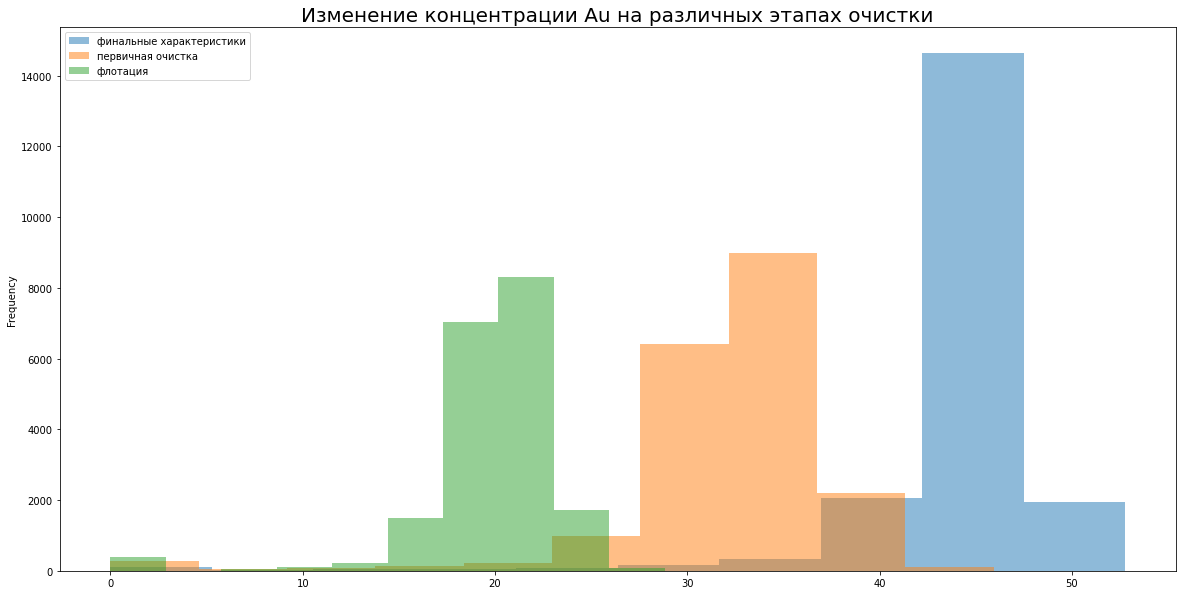

In [ ]:
func_concentrate(df_full['final.output.concentrate_au'], df_full['primary_cleaner.output.concentrate_au'],
                df_full['rougher.output.concentrate_au'], 'Изменение концентрации Au на различных этапах очистки')

Видно как растет концентрация золота в зависимости от этапа, на этапе флотации она самая низкая, при первичной очистке концентрация уже может достигать 40, а на финальной очистке мы наблюдаем самую высокую концентрацию.

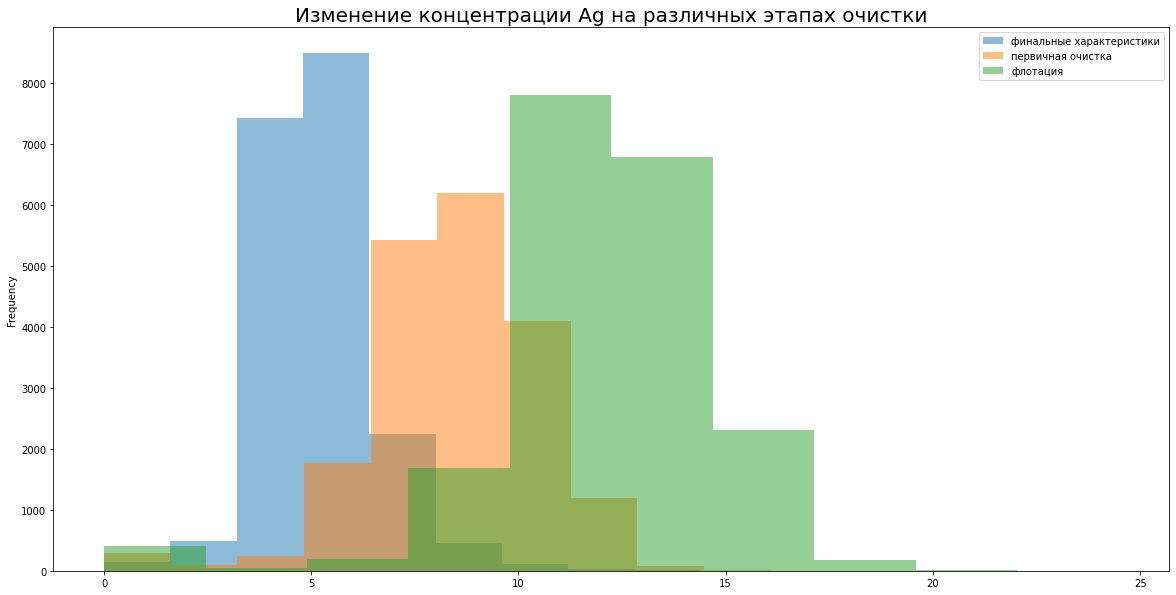

In [ ]:
func_concentrate(df_full['final.output.concentrate_ag'], df_full['primary_cleaner.output.concentrate_ag'],
                df_full['rougher.output.concentrate_ag'], 'Изменение концентрации Ag на различных этапах очистки')

Концентрация серебра в зависимости от этапа уменьшается, на этапе флотации она самая высокая, при первичной очистке концентрация снижается и на финальной очистке концентрация серебра самая низкая.

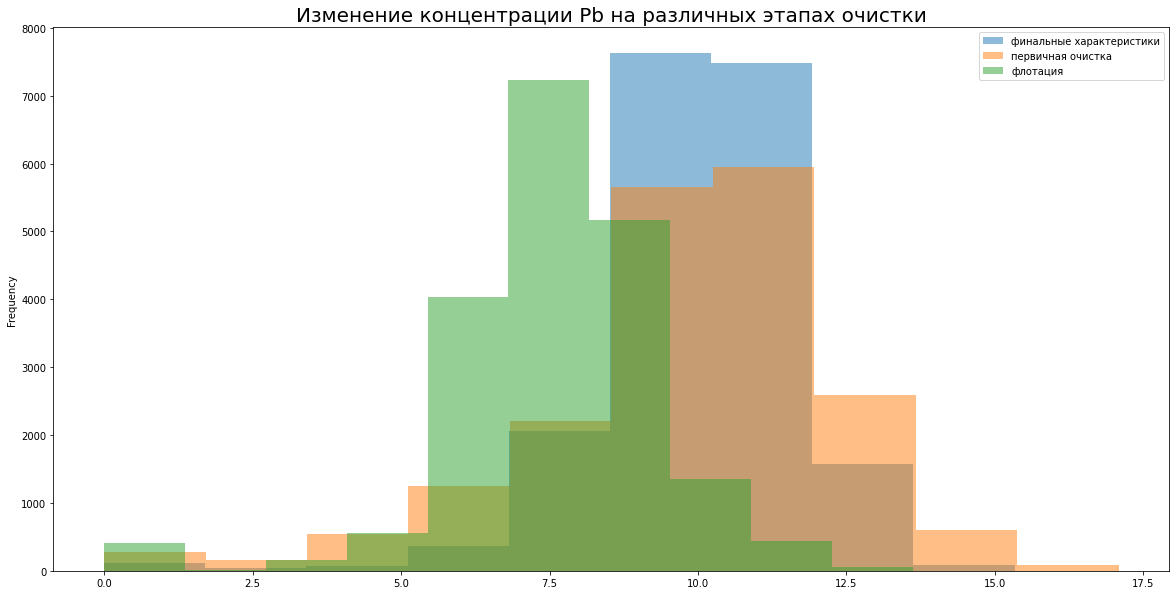

In [ ]:
func_concentrate(df_full['final.output.concentrate_pb'], df_full['primary_cleaner.output.concentrate_pb'],
                df_full['rougher.output.concentrate_pb'], 'Изменение концентрации Pb на различных этапах очистки')

Самая маленькая концентрация свинца на этапе флотации, на этапах первичной и финальной очистки концентрация находится в похожих пределах, т.о. видно, что после первичной очистки концентрация свинца особо не меняется.

###2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

In [ ]:
def func(train, test, title):
    plt.figure(figsize=(15,10))
    train.hist(density=True, bins=50, alpha=0.5, label='обучающая выборка')
    test.hist(density=True, bins=50, alpha=0.5, label='тестовая выборка')
    plt.legend(fontsize='large')
    plt.title(title)
    plt.show()

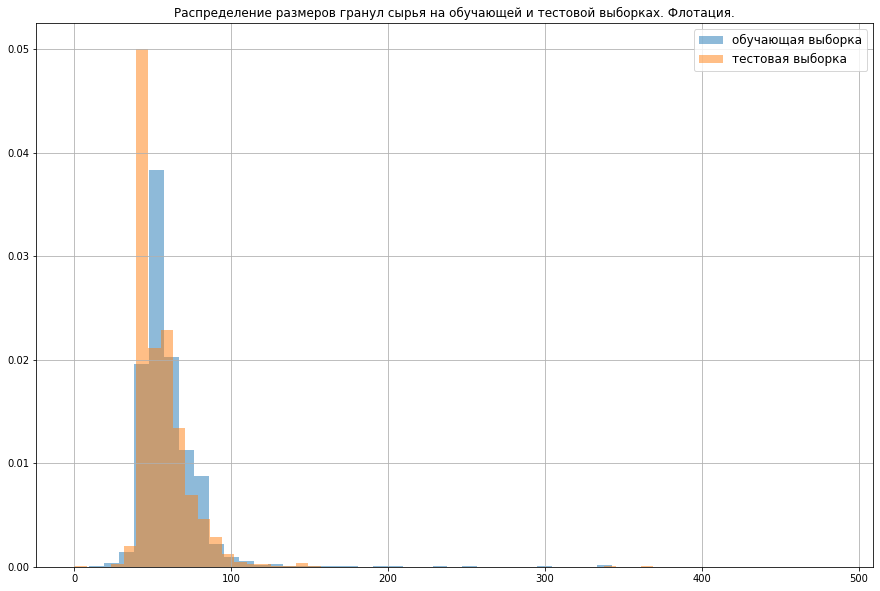

In [ ]:
func(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'],
     'Распределение размеров гранул сырья на обучающей и тестовой выборках. Флотация.')

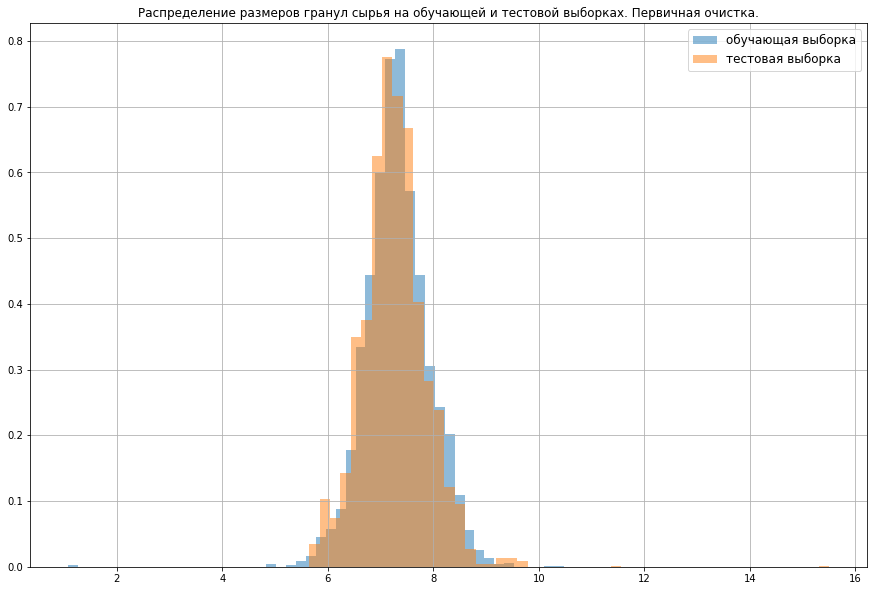

In [ ]:
func(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size'],
     'Распределение размеров гранул сырья на обучающей и тестовой выборках. Первичная очистка.')

Незначительные отличия распределения размеров гранул сырья на обучающей и тестовой выборках присутствуют. Данные различия оcобенно выражены на этапе флотации.

###2.3 Суммарная концентрация всех веществ на разных стадиях.

In [ ]:
df_full['rougher.input.feed_sum'] = (df_full['rougher.input.feed_ag'] +
                                     df_full['rougher.input.feed_pb'] +
                                     df_full['rougher.input.feed_sol'] +
                                     df_full['rougher.input.feed_au']
                                    )

In [ ]:
df_full['rougher.output.concentrate_sum'] = (df_full['rougher.output.concentrate_ag'] +
                                            df_full['rougher.output.concentrate_pb'] +
                                            df_full['rougher.output.concentrate_sol'] +
                                            df_full['rougher.output.concentrate_au']
                                            )

In [ ]:
df_full['final.output.concentrate_sum'] = (df_full['final.output.concentrate_ag'] +
                                          df_full['final.output.concentrate_pb'] +
                                          df_full['final.output.concentrate_sol'] +
                                          df_full['final.output.concentrate_au']
                                          )

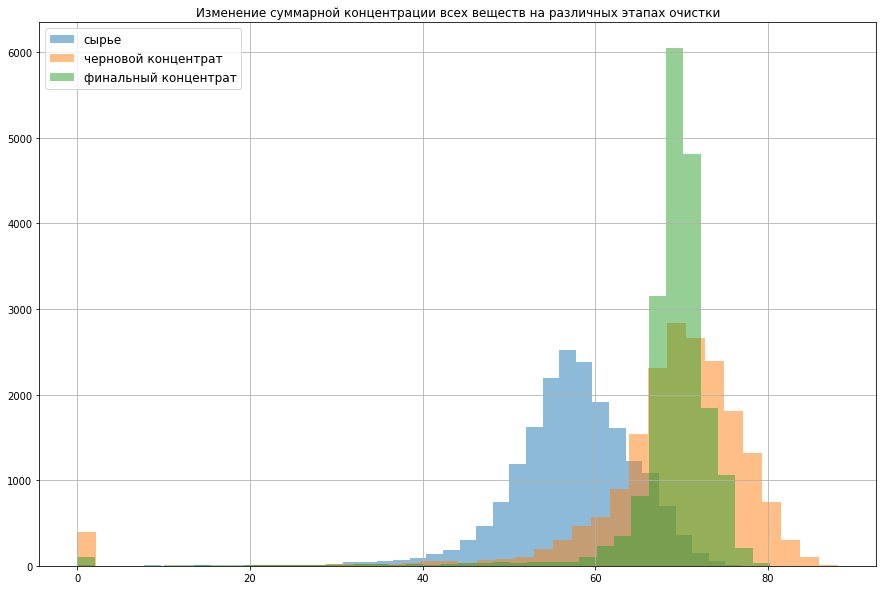

In [ ]:
plt.figure(figsize=(15,10))
df_full['rougher.input.feed_sum'].hist(bins=40, alpha=0.5, label='сырье')
df_full['rougher.output.concentrate_sum'].hist(bins=40, alpha=0.5, label='черновой концентрат')
df_full['final.output.concentrate_sum'].hist(bins=40, alpha=0.5, label='финальный концентрат')
plt.legend(fontsize='large')
plt.title('Изменение суммарной концентрации всех веществ на различных этапах очистки')
plt.show()

Суммарная концентрация всех веществ в сырье находится преимущественно в промежутке 50-70, в черновом концентрате преимущественно - 65-80, в финальном концентрате - 65-70.

##3 Модель

###3.1 Функция для вычисления итоговой sMAPE

In [2]:
def func_smape(y, y_predict):
    y = pd.Series(y)
    y_predict = pd.Series(y_predict, index=y.index)
    smape = sum(abs(y-y_predict)/((abs(y)+abs(y_predict))/2))/len(y)*100
    return smape

In [ ]:
def func_smape_total(smape_rougher, smape_final):
    smape_total = 0.25*smape_rougher + 0.75*smape_final
    return smape_total

In [ ]:
smape = make_scorer(func_smape)

###3.2 Обучение моделей и оценка их качества кросс-валидацией

**Модель LinearRegression**

In [ ]:
def func_lr(x_train, y_train):
    model_lr = LinearRegression()
    scores = cross_val_score(model_lr, x_train, y_train, scoring=smape, cv=5)
    scores_mean = sum(scores)/len(scores)
    return scores_mean

In [ ]:
smape_mean_final = func_lr(features_train, target_train_final)

In [ ]:
smape_mean_rougher = func_lr(features_train, target_train_rougher)

In [ ]:
smape_total_lr = func_smape_total(smape_mean_rougher, smape_mean_final)

In [ ]:
print('Итоговое sMAPE LinearRegression:', smape_total_lr)

Итоговое sMAPE LinearRegression: 10.703837329621917


**Модель DecisionTreeRegressor**

In [ ]:
def func_dt(x_train, y_train_r, y_train_f):
    best_model_dt = None
    best_smape_total_dt = 100
    depth = 0
    for i in range(1,30):
        model_dt = DecisionTreeRegressor(random_state=12345, criterion='poisson', max_depth = i)
        smape_r = cross_val_score(model_dt, x_train, y_train_r, scoring=smape, cv=5)
        smape_mean_r = sum(smape_r)/len(smape_r)
        smape_f = cross_val_score(model_dt, x_train, y_train_f, scoring=smape, cv=5)
        smape_mean_f = sum(smape_f)/len(smape_f)
        smape_total_dt = func_smape_total(smape_mean_r, smape_mean_f)
        if smape_total_dt < best_smape_total_dt:
            best_model_dt = model_dt
            best_smape_total_dt = smape_total_dt
            depth = i
    return best_smape_total_dt, depth

In [ ]:
%%time
best_smape_total_dt, depth = func_dt(features_train, target_train_rougher, target_train_final)

CPU times: user 1min 25s, sys: 610 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
print('Итоговое sMAPE DecisionTreeRegressor:', best_smape_total_dt, 'при depth =', depth)

Итоговое sMAPE DecisionTreeRegressor: 11.509018177661627 при depth = 8


**Модель RandomForestRegressor**

In [ ]:
def func_rf(x_train, y_train_r, y_train_f):
    best_model_rf = None
    best_smape_total_rf = 100
    n_estimators = 0
    max_depth = 0
    for est in range(1, 100):
        for depth in range(1, 15):
            model_rf = RandomForestRegressor(random_state=12345, n_estimators=est,
                                              max_depth=depth, criterion='poisson')
            smape_r = cross_val_score(model_rf, x_train, y_train_r, scoring=smape, cv=5)
            smape_mean_r = sum(smape_r)/len(smape_r)
            smape_f = cross_val_score(model_rf, x_train, y_train_f, scoring=smape, cv=5)
            smape_mean_f = sum(smape_f)/len(smape_f)
            smape_total_rf = func_smape_total(smape_mean_r, smape_mean_f)
            if smape_total_rf < best_smape_total_rf:
                best_model_rf = model_rf
                best_smape_total_rf = smape_total_rf
                n_estimators = est
                max_depth = depth
        return best_smape_total_rf, n_estimators, max_depth

In [ ]:
%%time
best_smape_total_rf, n_estimators, max_depth  = func_rf(features_train, target_train_rougher, target_train_final)

CPU times: user 14.1 s, sys: 55.9 ms, total: 14.2 s
Wall time: 14.2 s


In [ ]:
print('Итоговое sMAPE DecisionTreeRegressor:', best_smape_total_rf,
      'при n_estimators =', n_estimators, 'и max_depth =', max_depth)

Итоговое sMAPE DecisionTreeRegressor: 11.530461658286633 при n_estimators = 1 и max_depth = 3


Лучший показатель итогового sMAPE 10.703837329621917 у модели LinearRegression, у модели DecisionTreeRegressor лучший результат итогового sMAPE 11.530461658286633 при n_estimators = 1 и max_depth = 3, у модели DecisionTreeRegressor лучший результат итогового sMAPE 11.509018177661627 при depth = 8.

**Проверка лучшей модели на тестовой выборке**

In [ ]:
(features_train.columns == features_test.columns).all() # Проверка колонок

True

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train_rougher)
predicted_test_rouger = model.predict(features_test)
smape_rougher = func_smape(target_test_rougher, predicted_test_rouger)

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train_final)
predicted_test_final = model.predict(features_test)
smape_final = func_smape(target_test_final, predicted_test_final)

In [ ]:
smape_total = func_smape_total(smape_rougher, smape_final)
print('Итоговое sMAPE:', smape_total)

Итоговое sMAPE: 9.887034904109655


In [ ]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train_final)
predicted_dummy_final = model_dummy.predict(features_test)
smape_dummy_1 = func_smape(target_test_final, predicted_dummy_final)

In [ ]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train_rougher)
predicted_dummy_rouger = model_dummy.predict(features_test)
smape_dummy_2 = func_smape(target_test_rougher, predicted_dummy_rouger)

In [ ]:
smape_total_dummy = func_smape_total(smape_dummy_1, smape_dummy_2)
print('Итоговое sMAPE:', smape_total_dummy)

Итоговое sMAPE: 10.352712742790175


При тестировании лучшая модель на кросс-валидации показала хорошие результаты на 10 % лучше, чем константная модель. Данную модель можно использовать с целью предсказания коэффициента восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

> Выводы

Для проекта были использованы сырые данные с параметрами добычи и очистки золота.
В данных присутствовали пропуски, которые были заполнены соседними по времени параметрами, т.к. в условии было указано, что соседние по времени параметры часто похожи. Была проведена проверка правильности расчета эффективности обогащения.
При формировании обучающей и тестовой выборок были удалены столбцы, характеризующие текущее состояние этапа, т.о. для обучения и тестирования модели были использованы только  данные характеризующие параметры сырья. Была проведена стандартизация данных.
В проекте был проведен анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки, который показал, что концентрация золота растет в зависимости от этапа (на этапе флотации она самая низкая, при первичной очистке - может достигать 40, а на финальной очистке - самая высокая концентрация). Концентрация серебра в зависимости от этапа наоборот уменьшается (на этапе флотации - самая высокая, при первичной очистке снижается, на финальной очистке - самая низкая). Самая маленькая концентрация свинца на этапе флотации, на этапах первичной и финальной очистки концентрация находится в похожих пределах.
Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках показало, что незначительные отличия распределения размеров гранул сырья присутствуют и что данные различия оcобенно выражены на этапе флотации, однако т.к. они не сильно отличаются на оценку модели они не повлияют.
Суммарная концентрация всех веществ в сырье находится преимущественно в промежутке 50-70, в черновом концентрате преимущественно - 65-80, в финальном концентрате - 65-70.
Были обучены модели алгоритмами LinearRegression, DecisionTreeRegressor, RandomForestRegressor и проверено их качество с помощью кросс-валидации, для оценки качества моделей использовалась метрика sMAPE, для расчета которой была написана функция. Лучший показатель итогового sMAPE у модели LinearRegression. Она была проверена на тестовой выборке. При тестировании данная модель показала хорошие результаты на 10 % лучше, чем константная модель. Модель LinearRegression  можно использовать с целью предсказания коэффициента восстановления золота из золотосодержащей руды, она поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
